### Now lets work on Conditional Langgraph workflow

![](img/conditional_langgraph.png)

We will cover it with two examples -> 

    1. Non LLM based -> math (quadratic equation) -> for buidling the understanding of the conditional workflow
    2. LLM based -> Customer support

### Quadratic Equation Workflow

![](img/quadratic_eq1.png)
![](img/quadratic_eq2.png)


In [14]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Literal
from dotenv import load_dotenv


In [21]:
class QuadState(TypedDict):
    a: int
    b: int
    c: int

    equation: str
    discriminant: int
    result: str


In [30]:
def show_equation(state: QuadState):
    equation = f'{state['a']}x^2 + {state['b']}x + {state['c']}'

    return {
        'equation': equation
    }

def calculate_discriminant(state: QuadState):
    discriminant = state['b']**2 - (4 * state['a'] * state['c'])

    return {
        'discriminant':discriminant
    }

# -b +(or)- sqrt(D)/2a      -> [D>0]
def real_roots(state: QuadState):
    root1 = (-state['b'] + state['discriminant']**0.5)/(2 * state['a'])
    root2 = (-state['b'] - state['discriminant']**0.5)/(2 * state['a'])

    result = f'The roots are {root1} and {root2}.'

    return {
        'result':result
    }
    
# -b /2a       -> here [D=0]
def repeated_roots(state: QuadState):
    root1 = -state['b']/(2 * state['a'])

    result = f'Only repeating roots is {root1}.'

    return {
        'result':result
    }

# [D<0]
def no_real_roots(state:QuadState):
    result = f'No real roots exist for this quadratic equation.'
    return {
        'result': result
    }

def check_condition(state: QuadState) -> Literal["real_roots", "repeated_roots", "no_real_roots"]:
    if state['discriminant'] > 0:
        return "real_roots"
    elif state['discriminant'] == 0:
        return "repeated_roots"
    else:
        return "no_real_roots"

In [31]:
# define the state
graph = StateGraph(QuadState)

# add nodes
graph.add_node('show_equation', show_equation)
graph.add_node('calculate_discriminant', calculate_discriminant)
graph.add_node('real_roots', real_roots)
graph.add_node('repeated_roots', repeated_roots)
graph.add_node('no_real_roots', no_real_roots)

# add edges
graph.add_edge(START, 'show_equation')
graph.add_edge('show_equation', 'calculate_discriminant')

graph.add_conditional_edges('calculate_discriminant', check_condition)

graph.add_edge('real_roots', END)
graph.add_edge('repeated_roots', END)
graph.add_edge('no_real_roots', END)

# compile the graph
workflow = graph.compile()

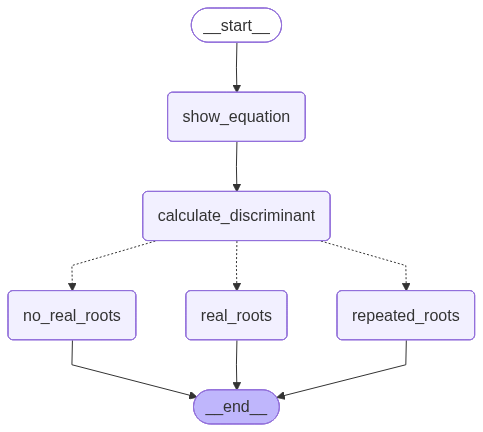

In [32]:
workflow

In [33]:
initial_state = {
    'a':1,
    'b':2,
    'c':1
}

final_state = workflow.invoke(initial_state)

print(final_state)

{'a': 1, 'b': 2, 'c': 1, 'equation': '1x^2 + 2x + 1', 'discriminant': 0, 'result': 'Only repeating roots is -1.0.'}


### LLM based -> Customer support

![](img/customer_support.png)

In [19]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [20]:
load_dotenv()

True

In [21]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite"
)

In [22]:
# define the schema for structured output
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="Sentiment of the review")

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Perfromance", "Bug", "Support", "Other"] = Field(description="The category of the issue mentioned in the review")
    tone: Literal["angry", "frustrated", "diasppointed", "calm"] = Field(description="What is the emontion tone expressed by the user")
    urgency: Literal["low", "medium", "high"] = Field(description="How urgent or critical is the issue")
    

In [23]:
sentiment_structured_model = model.with_structured_output(SentimentSchema)

diagnosis_structured_model = model.with_structured_output(DiagnosisSchema)

In [16]:
# just testing
prompt = 'what was the sentiment of the following review - The software was good'

structured_model.invoke(prompt).sentiment

'positive'

In [24]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: dict
    response: str

In [30]:
def find_sentiment(state: ReviewState):
    prompt = f'what is the sentiment of the following review - {state['review']}'
    sentiment = sentiment_structured_model.invoke(prompt)

    return {
        'sentiment': sentiment
    }

def check_sentiment(state: ReviewState) -> Literal['run_diagnosis', 'positive_response']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'

def run_diagnosis(state: ReviewState):
    prompt = f"""Diagnose this negative review {state['review']}' \n
                Return issue_type, tone and urgency.
    """
    diagnosis = diagnosis_structured_model.invoke(prompt)

    return {
        'diagnosis':diagnosis.model_dump()
    }
    
def positive_response(state: ReviewState):
    prompt = f"""
    Write a warm thankyou message in response to the review: \n
        {state['review']} \n
        Also, kindly ask the user to leave feedback on our website.
    """
    response = model.invoke(prompt).content
    return {
        'response':response
    }

def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant.
        The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as
        '{diagnosis['urgency']}'.
        Write an empathetic, helpful resolution message.
    """
    response = model.invoke(prompt).content

    return {
        'response':response
    }

In [31]:
# define the state
graph = StateGraph(ReviewState)

# add nodes
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)
graph.add_node('positive_response', positive_response)

# add edges
graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

graph.add_edge('positive_response', END)

# compile the graph
workflow = graph.compile()

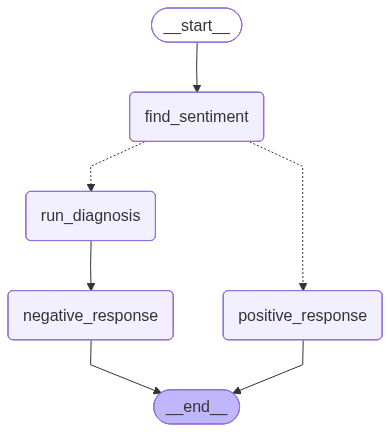

In [32]:
workflow

In [33]:
initial_state = {
    'review': " I bought a Samsung washing machine from a nearby Croma store. It was working fine for a few months, but one day it suddenly stopped working while washing clothes. At first, I thought it might be a power issue, so I checked, but there was no power failure. I then called customer care and asked them to send a technician. However, the representative was not able to understand the problem at first. After explaining it several times, he finally understood and said a technician would come in two days. I waited, but no one came. I called customer care again, and they informed me that no technicians were available at the moment and that someone would arrive within the next two days. Again, no technician showed up. Frustrated, I called them one last time and ended up yelling at the representative, which led to him misbehaving as well. I disconnected the call and decided to visit the Croma store directly. They resolved my problem there."
}

final_state = workflow.invoke(initial_state)

final_state

{'review': ' I bought a Samsung washing machine from a nearby Croma store. It was working fine for a few months, but one day it suddenly stopped working while washing clothes. At first, I thought it might be a power issue, so I checked, but there was no power failure. I then called customer care and asked them to send a technician. However, the representative was not able to understand the problem at first. After explaining it several times, he finally understood and said a technician would come in two days. I waited, but no one came. I called customer care again, and they informed me that no technicians were available at the moment and that someone would arrive within the next two days. Again, no technician showed up. Frustrated, I called them one last time and ended up yelling at the representative, which led to him misbehaving as well. I disconnected the call and decided to visit the Croma store directly. They resolved my problem there.',
 'sentiment': SentimentSchema(sentiment='neg